In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions
using LinearAlgebra
using Test

using ForwardDiff
# using ReverseDiff
# using FiniteDifferences

using Revise
using EuclidianNormalizingFlows

┌ Info: Precompiling EuclidianNormalizingFlows [eb90128f-7c94-4cd6-9130-4bb7c9abac9d]
└ @ Base loading.jl:1423


In [2]:
# Compare transformation results & gradients using Finite Differences and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 20,
        ndims = 10,
        nparams = 10,
        nsmpls = 100,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions

        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 5), ndims, nsmpls)
        
        try 
            
            trafo_frwd = TrainableRQSpline(w,h,d)
            trafo_bcwd = TrainableRQSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            for j in 1:size(x, 2)
                xrun = x[:,j]
                
#                 autodiff_jac = FiniteDifferences.jacobian(algo, xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )[1]
                autodiff_jac = ForwardDiff.jacobian(xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )
                @test log(abs(det(autodiff_jac))) ≈ jac_frwd[1,j]
                @test log(abs(det(autodiff_jac))) ≈ -jac_bcwd[1, j]
            end

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(par,h,d), x), w)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(par,h,d), x), w)
            @test a_run ≈ gradvals.widths

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,par,d), x), h)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,par,d), x), h)
            @test a_run ≈ gradvals.heights

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,h,par), x), d)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,h,par), x), d)
            @test a_run ≈ gradvals.derivatives
            
            println("Test no. $i successfull!")
        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

Test no. 1 successfull!
Test no. 2 successfull!
Test no. 3 successfull!
Test no. 4 successfull!
Test no. 5 successfull!
Test no. 6 successfull!
Test no. 7 successfull!
Test no. 8 successfull!
Test no. 9 successfull!
Test no. 10 successfull!
Test no. 11 successfull!
Test no. 12 successfull!
Test no. 13 successfull!
Test no. 14 successfull!
Test no. 15 successfull!
Test no. 16 successfull!
Test no. 17 successfull!
Test no. 18 successfull!
Test no. 19 successfull!
Test no. 20 successfull!


# 2D fit: 

In [3]:
nparams = 20
nsmpls = 6000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = TrainableRQSpline(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [4]:
@test x ≈ TrainableRQSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(TrainableRQSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (TrainableRQSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((TrainableRQSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [0.22635793963693587 -0.513616865962038 … 1.5776729109677163 1.58459575232127; -0.23836137580693564 0.040373532197889986 … -1.0152282320188306 -0.3313487763308022] ≈ [0.22635793963693587 -0.5136168659620379 … 1.5776729109677163 1.58459575232127; -0.2383613758069356 0.040373532197889986 … -1.0152282320188304 -0.3313487763308022]

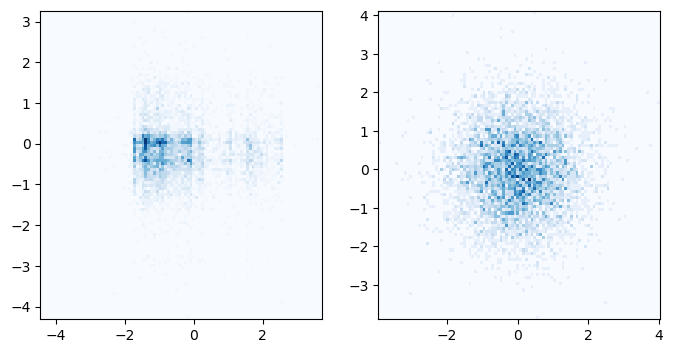

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.937466901357094, -3.857765414754657, -3.77806392815222, -3.6983624415497833, -3.6186609549473463, -3.5389594683449093, -3.4592579817424722, -3.379556495140035, -3.299855008537598, -3.2201535219351616  …  3.3153683794646684, 3.395069866067105, 3.4747713526695425, 3.554472839271979, 3.6341743258744166, 3.713875812476853, 3.7935772990792898, 3.8732787856817272, 3.952980272284164, 4.032681758886601], [-3.8911158291683163, -3.811182584444631, -3.7312493397209456, -3.65131609499726, -3.5713828502735745, -3.491449605549889, -3.411516360826204, -3.331583116102518, -3.2516498713788327, -3.1717166266551473  …  3.3828094406870592, 3.4627426854107446, 3.54267593013443, 3.6226091748581153, 3.7025424195818006, 3.782475664305486, 3.862408909029172, 3.9423421537528576, 4.022275398476543, 4.102208643200228], PyObject <matplotlib.collections.QuadMesh object at 0x7fa74909d3a0>)

In [5]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [6]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  TrainableRQSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 15 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = TrainableRQSpline([1.0669729247795674 1.0665714203483638 … 1.0148028503328812 1.0148028503328812; 1.1018282807734543 1.099672516063391 … 1.137266223371498 1.137266223371498], [0.8057555127746265 0.7835876011362414 … 1.1125530413481717 1.1125530413481717; 1.0958092458413617 1.0907537606626194 … 0.8509318613772611 0.8509318613772611], [1.6318577762746813 0.4877690448802739 … 0.09869788610047461 1.0; 1.5812093924712045 0.9972067436802934 … 1.0 1.0]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [5.51682 5.51763 … 4.15959 4.15959; 2.63382 2.62789 … 2.61411 2.61411]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.134958 0.13171 … 0.13569 0.13569; 0.243399 0.241974 … 0.196538 0.196538]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [3.22889e-5 2.15238e-6 … 2.52156e-6 1.19209e-7; 9.66149e-6 4.73434e-5 … 1.19209e-7 1.19209e-7])), negll_history = [2.7487459115295603, 2.864809577422111, 2.7492655146198945, 2.5652422854771997, 2.3690726294874485, 2

In [7]:
yhat = r.result(x)

2×6000 Matrix{Float64}:
  0.812807   0.185727  0.243415   1.06568   …  -1.27982   1.28642   1.29557
 -0.0359793  0.494229  0.67347   -0.642727     -1.40289  -1.30017  -0.184214

In [8]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.017523705544531882; 0.04729161847674135;;]
std(yhat, dims = 2) = [0.996418500704066; 1.0005505033466442;;]


2×1 Matrix{Float64}:
 0.996418500704066
 1.0005505033466442

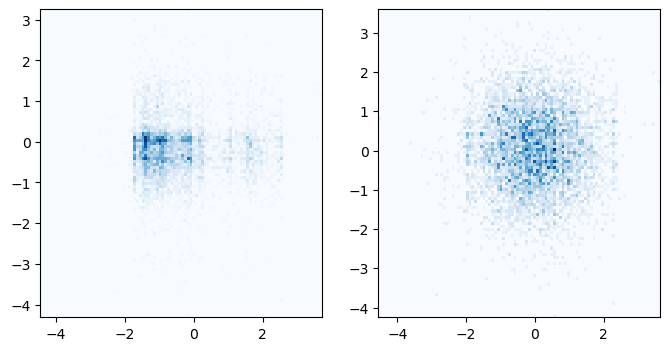

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.555581723488948, -4.473564995171166, -4.391548266853384, -4.309531538535602, -4.227514810217819, -4.145498081900038, -4.063481353582255, -3.9814646252644734, -3.8994478969466915, -3.8174311686289095  …  2.9079405534292198, 2.989957281747002, 3.0719740100647837, 3.153990738382566, 3.2360074667003476, 3.31802419501813, 3.4000409233359123, 3.4820576516536947, 3.5640743799714754, 3.6460911082892573], [-4.248609302281467, -4.1701421875685085, -4.09167507285555, -4.013207958142592, -3.9347408434296343, -3.856273728716676, -3.777806614003718, -3.6993394992907596, -3.6208723845778015, -3.5424052698648434  …  2.8918981365977228, 2.970365251310681, 3.048832366023639, 3.127299480736597, 3.205766595449555, 3.284233710162513, 3.362700824875472, 3.4411679395884303, 3.5196350543013883, 3.5981021690143464], PyObject <matplotlib.collections.QuadMesh object at 0x7fa74a4b7df0>)

In [9]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

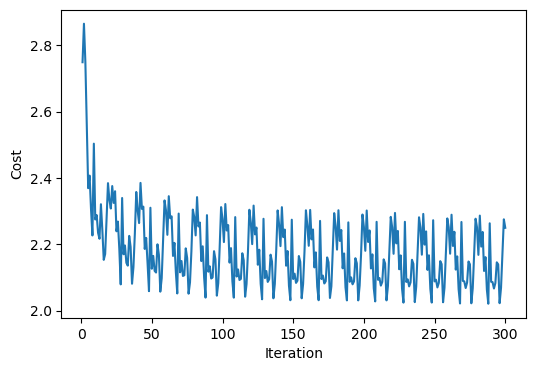

PyObject Text(0.5, 24.0, 'Iteration')

In [10]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [11]:
nparams = 20 # 1180 parameters in total
nsmpls = 6000
ndims = 200
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [12]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    TrainableRQSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

200×6000 Matrix{Float64}:
 -0.691889   -3.18616   -0.391503  …  -0.603119  -2.09718    -0.411717
 -0.281904   -2.0997    -1.33369      -0.734523  -3.77388    -1.14244
 -2.97475    -1.18127   -1.87359      -2.76309   -1.05432    -1.62987
  1.3175     -0.119553   2.61351       1.90314   -0.459982    2.49269
  0.671494   -0.500254   0.927962     -1.43332    0.400622   -0.218028
 -1.56722     0.694309  -1.24866   …  -1.70382   -0.145199    0.367099
 -1.81162     0.149531  -0.429881     -2.33556   -0.129952    0.926194
  1.70038     2.47354    1.54066      -0.139117   2.40609     2.62671
 -0.662593   -1.71752   -2.13484      -1.71732   -0.0436372  -1.77626
 -1.20334    -0.807311  -2.00828      -0.875717  -1.36896    -1.89271
  0.413894    1.20291    0.892127  …   0.663175   1.26332    -0.106922
 -0.0204932   1.81929   -0.390894      2.03912    0.0445527   0.148286
  3.39629     0.605152   3.63561       0.856085   0.754889   -0.692226
  ⋮                                ⋱                     

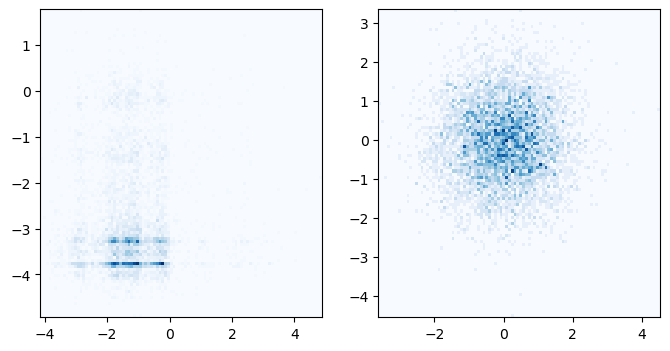

In [13]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [19]:
initial_trafo = 
    TrainableRQSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

@time r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

 13.845783 seconds (396.81 M allocations: 29.229 GiB, 35.13% gc time)


In [15]:
yhat = r.result(x);

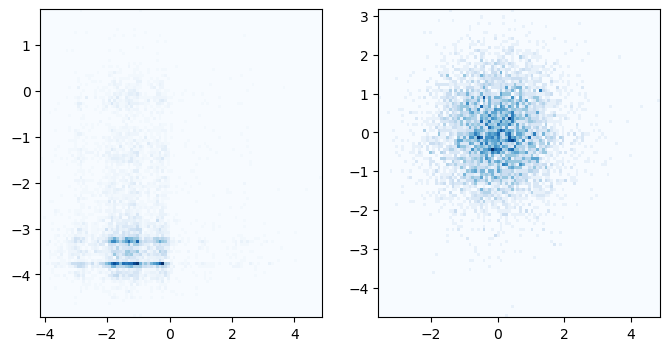

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.5760123271603077, -3.491559357275769, -3.4071063873912304, -3.322653417506692, -3.2382004476221535, -3.153747477737615, -3.0692945078530762, -2.9848415379685376, -2.900388568083999, -2.8159355981994603  …  4.109207932332703, 4.193660902217243, 4.27811387210178, 4.36256684198632, 4.447019811870858, 4.5314727817553955, 4.615925751639935, 4.700378721524473, 4.784831691409012, 4.86928466129355], [-4.765852938591611, -4.6864187406969435, -4.606984542802277, -4.527550344907609, -4.448116147012941, -4.368681949118274, -4.2892477512236065, -4.20981355332894, -4.130379355434272, -4.050945157539604  …  2.4626590698231254, 2.542093267717793, 2.62152746561246, 2.700961663507128, 2.7803958614017947, 2.8598300592964625, 2.9392642571911303, 3.018698455085797, 3.098132652980465, 3.1775668508751327], PyObject <matplotlib.collections.QuadMesh object at 0x7fa74f2208b0>)

In [17]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

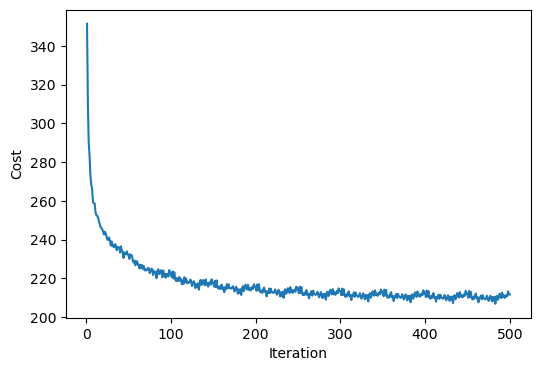

PyObject Text(0.5, 24.0, 'Iteration')

In [18]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")